# Analyzing Assessed Value of the Downtown Mall

## Goals: 

    *Provide descriptive statistics of assessed value over time for the City of Charlottesville's downtown mall

    *Map and chart assessed values over time

## Step 1: Aquire Data

### Assessment Values
    Charlottesville's Open Data Portal : http://opendata.charlottesville.org/

    Real Estate (All Assessments) Dataset : http://opendata.charlottesville.org/datasets/real-estate-all-assessments

        * On the Real Estate dataset page, in the upper right corner of the window under the map click the APIs             drop down
        * Copy the GeoJSON link
        * Use the GeoJSON link to pull data directly from the Open Data portal using the code below

    Parcel Area Data : http://opendata.charlottesville.org/datasets/parcel-boundary-area

### List of properties to use in analysis

Charlottesville GIS Viewer: https://gisweb.charlottesville.org/GisViewer/

    * Under Map option, turn on 'Parcels & Buildings' > 'Parcels'. Turn everything else off.

    * Zoom to area of interest on map

    * Under 'Tools' select 'Identify'

    * In 'Identify' toolbar select 'Custom Shape' and under 'Layer' select 'Parcels'

    * Using mouse on map, click boundary around area of interest

    * A list will appear in the left panel of the web page

    * In the panel click 'Tools' > 'Export All to Excel'

    * A window named 'Export Results' will open when your download is ready.

    * Click 'View Export' and save file to your project directory

<img src="https://github.com/strmwtr/downtown_assessments/blob/master/img/getting_pin_list.png?raw=true">

# Step 2: Prepare Data

In [1]:
%matplotlib inline

## Import .xls retrieved from the GIS Viewer into pandas

In [2]:
#Import pandas module
import pandas as pd 

#Path to the .xls retrieve from the GIS Viewer
f = r'./data/pin_exp.xls'

#Create a dataframe that reads the .xls file
df = pd.read_excel(f)

#### Remove all MULTIPIN parcels from df

In [3]:
#Identify all rows in df where MULTIPIN column is not equal to 1
not_multipin = df['MULTIPIN'] != 1
#Create a new dataframe that only contains the rows identified in not_multipin
df = df[not_multipin]
#df.head()

## Access json file for parcel areas

In [4]:
formatted_gpins = [str(x) for x in df['GPIN'].unique()]
formatted_gpins = formatted_gpins
formatted_gpins = ','.join(formatted_gpins)

parcel_area_url = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_1/MapServer/43/query?where=GPIN%20in%20({formatted_gpins})&outFields=*&outSR=4326&f=json"

#print(parcel_area_url)

## Preparing annual assessment data

Charlottesville's Open Data Portal : http://opendata.charlottesville.org/

Real Estate (All Assessments) Dataset : http://opendata.charlottesville.org/datasets/real-estate-all-assessments

* On the Real Estate dataset page, in the upper right corner of the window under the map click the 'API Explorer' tab
* Copy the Query URL link and augment the link to match your query
* Use the augmented link to pull data directly from the Open Data portal using the code below

In [5]:
# importing the requests library 
import requests

formatted_pins = [f'%27{x}%27' for x in df['PIN'].unique()]
formatted_pins_1 = formatted_pins
formatted_pins_1 = ','.join(formatted_pins_1)

url1 = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_2/MapServer/2/query?where=UPPER(ParcelNumber)%20in%20({formatted_pins_1})%20&outFields=ParcelNumber,LandValue,ImprovementValue,TotalValue,TaxYear&outSR=4326&f=json"

r1 = requests.get(url1)

d1 = r1.json()

#print(r1)

After testing the requests.get(url), I can request up to 120 parcels at a time before recieving a 404 Error. I have 126 parcels of interest. I will break my request up into 2 parts, [:75] and [75:].

## Create data series based on features and combine data frames into a single df

In [6]:
df1 = pd.DataFrame(d1['features'])

## Create a single data frame based on combined series data

In [7]:
assessments = pd.DataFrame([x for x in df1['attributes']], dtype = 'object')
assessments = assessments.astype({'TaxYear': 'int64', 'ImprovementValue': 'int64','LandValue': 'int64','TotalValue': 'int64', 'ParcelNumber': 'str'})
#assessments.head()

## Create data frame from df that holds PIN and GPIN. Will be used to joined assessments, so that parcel area can be joined with assessments

In [8]:
df_key = pd.DataFrame(df[['PIN','GPIN']], dtype = 'str')
#df_key.head()

In [9]:
d = pd.merge(assessments, df_key, how='inner', left_on=['ParcelNumber'], right_on=['PIN'])
#print(assessments.shape, d.shape)

# Step 3: Analyze

In [10]:
#Create data frame of assessed values for all parcels by specified year
year_min = int(d['TaxYear'].min())
year_max = int(d['TaxYear'].max())
years = (x for x in range(year_min, year_max+1))
#total_val_col = d['TotalValue'][d['TaxYear'] == 2019].mean()
assessment_chart_list = []
for x in years:
    year_col = x
    land_col_mean = d['LandValue'][d['TaxYear'] == x].mean()
    imp_col_mean = d['ImprovementValue'][d['TaxYear'] == x].mean()
    total_col_mean = d['TotalValue'][d['TaxYear'] == x].mean()
    
    land_col_min = d['LandValue'][d['TaxYear'] == x].min()
    imp_col_min = d['ImprovementValue'][d['TaxYear'] == x].min()
    total_col_min = d['TotalValue'][d['TaxYear'] == x].min()
    
    land_col_max = d['LandValue'][d['TaxYear'] == x].max()
    imp_col_max = d['ImprovementValue'][d['TaxYear'] == x].max()
    total_col_max = d['TotalValue'][d['TaxYear'] == x].max()
    
    assessment_chart_list.append(
        [year_col, land_col_mean, imp_col_mean, total_col_mean, land_col_min, imp_col_min, 
         total_col_min, land_col_max, imp_col_max, total_col_max])
assessment_chart_cols = ['Tax Year', 'Mean Land Value', 'Mean Improvement Value', 'Mean Total Value',
    'Min Land Value', 'Min Improvement Value', 'Min Total Value', 'Max Land Value', 'Max Improvement Value', 
    'Max Total Value']
assessment_chart_df = pd.DataFrame(assessment_chart_list, columns = assessment_chart_cols)
assessment_chart_df
#mean_total_vals = [d['TotalValue'][d['TaxYear'] == x].mean() for x in years]
#x = d['ParcelNumber'].str.contains('2800371C0')
#y = d[x].sort_values('TaxYear')
#y.plot(x='TaxYear', y='TotalValue', figsize=(15,10), grid=True)

,Tax Year,Mean Land Value,Mean Improvement Value,Mean Total Value,Min Land Value,Min Improvement Value,Min Total Value,Max Land Value,Max Improvement Value,Max Total Value
0,1997,126277.192982,5.440325e+05,6.703096e+05,0,0,0,1528400,8221600,9750000
1,1998,139863.157895,5.543623e+05,6.942254e+05,13700,0,22500,1910500,7839500,9750000
2,1999,150922.807018,5.869263e+05,7.378491e+05,15000,0,22500,2292700,8992300,11285000
3,2000,156554.385965,6.773149e+05,8.338693e+05,15000,0,22500,2292700,9035400,11285000
4,2001,169684.210526,7.262105e+05,8.958947e+05,15800,0,23600,2483700,9487200,11285000
5,2002,186028.070175,8.283219e+05,1.014350e+06,17400,0,23600,2674800,10435900,13075000
6,2003,200293.859649,8.824211e+05,1.082715e+06,19100,0,26000,2865000,10500000,13365000
7,2004,213970.689655,9.535422e+05,1.167513e+06,21000,0,28600,3151500,11550000,14701500
8,2005,242986.206897,1.099044e+06,1.342030e+06,24200,0,32900,3624200,12705000,16329200
9,2006,279434.482759,1.166400e+06,1.445834e+06,27800,0,37800,4167800,13340300,17508100


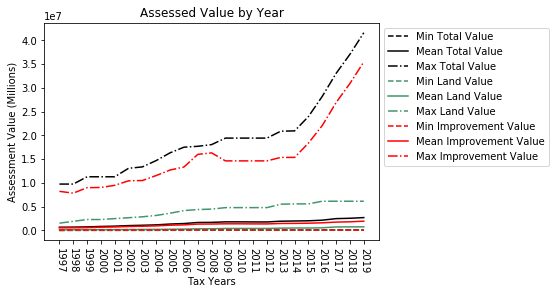

In [24]:
from matplotlib import pyplot as plt

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Total Value'], linestyle = '--', color = '#000000', label='Min Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Total Value'], linestyle = '-', color = '#000000', label='Mean Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Total Value'], linestyle = '-.', color = '#000000', label='Max Total Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Land Value'], linestyle = '--', color = '#41966d',  label='Min Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Land Value'], linestyle = '-', color = '#41966d', label='Mean Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Land Value'],  linestyle = '-.', color = '#41966d', label='Max Land Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Improvement Value'], linestyle = '--', color = '#ff0000', label='Min Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Improvement Value'], linestyle = '-', color = '#ff0000', label='Mean Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Improvement Value'], linestyle = '-.', color = '#ff0000', label='Max Improvement Value')

plt.title('Assessed Value by Year')
plt.xlabel('Tax Years')
plt.ylabel('Assessment Value (Millions)')

plt.xticks(range(assessment_chart_df['Tax Year'].min(), assessment_chart_df['Tax Year'].max()+1), rotation=270)
plt.yticks(range(0, int(assessment_chart_df['Max Total Value'].max()), 5000000))

plt.legend(bbox_to_anchor=(1,1))
plt.savefig('plot.png', dpi=300, edgecolor = 'w', orientation='landscape')

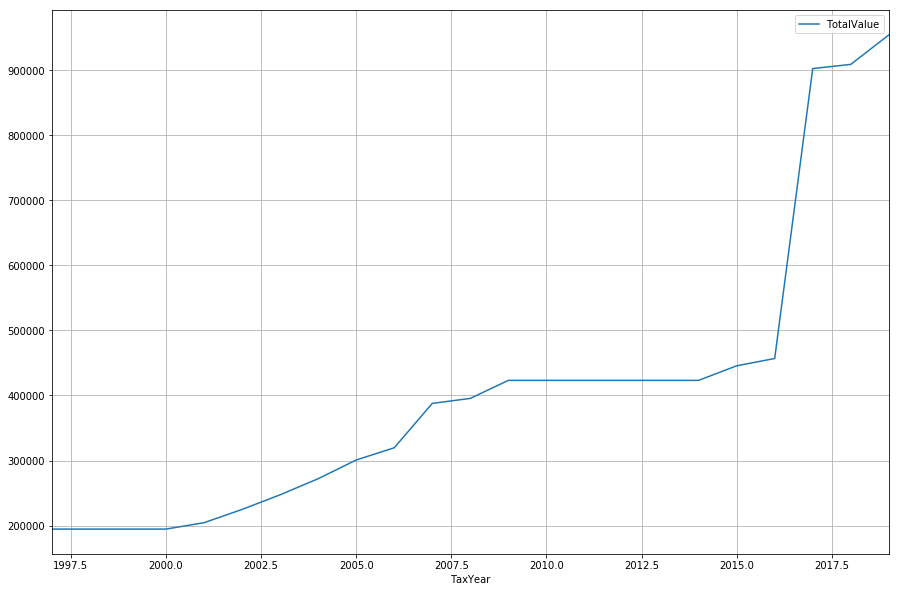

In [12]:
#Plot single parcel by tax year vs total value
x = d['ParcelNumber'].str.contains('2800371C0')
y = d[x].sort_values('TaxYear')
y.plot(x='TaxYear', y='TotalValue', figsize=(15,10), grid=True)

# Plot each parcels total, land, and improvement value across all years on 3 line graphs, one for each assessment type

# Map the same data as above via folium

# Create time lapse of maps